In [3]:
# using PyPlot
# include("acoustic_solver.jl")
# include("barycenter.jl")

# using Distributed
# using SharedArrays
# addprocs(11);

In [4]:
@everywhere include("inverse_prob.jl")
@everywhere include("code/barycenter.jl")

In [122]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;
x = range(0,step=h,length=Nx)
y = range(0,step=h,length=Ny)
    
Fs = 500;
dt = 1/Fs
Nt = 1501;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(6,2)
for i = 1:6
    source_position[i,:] = [5 20*(i-1)+1]
#     source_position[i,:] = [5 51]
end
source = repeat(source, 1, 6)

receiver_position = zeros(51,2)
for i = 1:51
    receiver_position[i,:] = [1, (i-1)*2+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
# c[50:end,:] .= 1.1
# c[30:40,30:60] .= 1.05
# c[60:80,60:80] .= 1.15
# c[30:50,20:40] .= 1.05
# c = imfilter(c, Kernel.gaussian(10));
    
c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[50:70,60:80] .= 1.05
for i = 1:Nx
    for j = 1:Ny
        if sqrt((x[i]-0.5).^2 + (y[j]-0.5).^2) < 0.2
            c0[i,j] = 1.05
        end
    end
end
            
    
# c = imfilter(c0, Kernel.gaussian(20));

cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 50
end

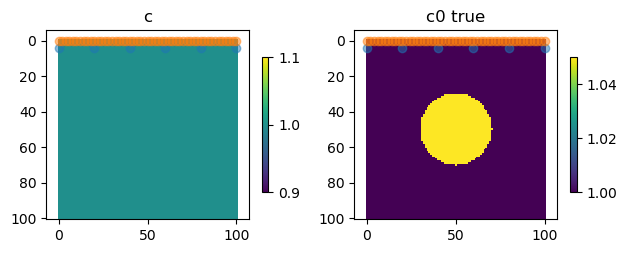

In [124]:
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0 true")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [125]:
# @time data, u = acoustic_eq_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time data0, u0 = acoustic_eq_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time datac, uc = acoustic_eq_solver(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time datac, uc = multi_solver_parallel(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);


  3.555837 seconds (4.31 k allocations: 173.172 KiB)
  3.410409 seconds (4.36 k allocations: 178.125 KiB)
  3.556776 seconds (4.37 k allocations: 178.547 KiB)


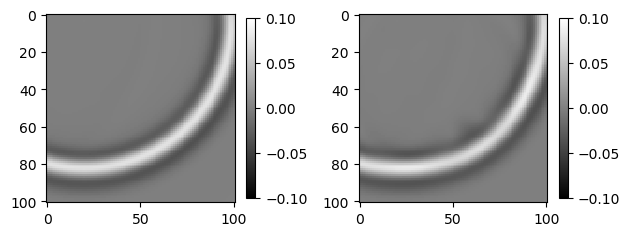

In [126]:
figure;
subplot(121); imshow(u[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

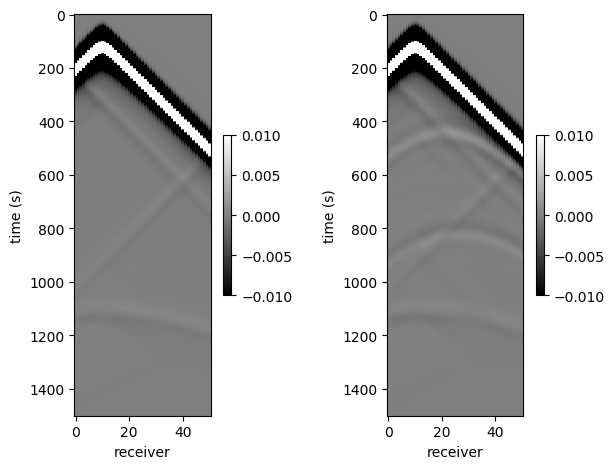

In [127]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [128]:
mi1 = minimum(data-datac)
mi2 = minimum(data0-datac)
mi = abs(min(mi1,mi2))
M = cost_matrix_1d(t, t; p=2)
@time adj_s, dd = adj_source_sinkhorn_parallel(data-datac, data0-datac, M; reg_p=0, reg=5e-3, reg_m=1e2, iterMax=100, verbose=false);

 16.650726 seconds (7.91 k allocations: 10.942 MiB, 0.01% gc time)


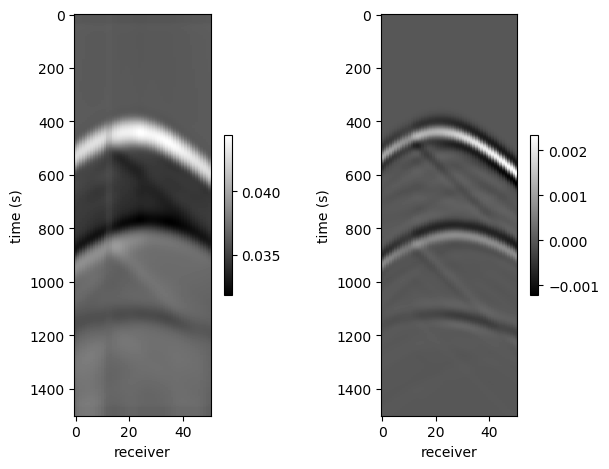

In [129]:
figure;
r_axis = 0:21
subplot(121); imshow(-adj_s[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); 
# clim([0.03,0.04])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,2]-data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [19]:
v = backward_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, adj_s, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

In [20]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad = uu[:,:,end:-1:1,:].*v;
grad = sum(grad, dims=[3,4])
grad = grad[:,:,1,1]

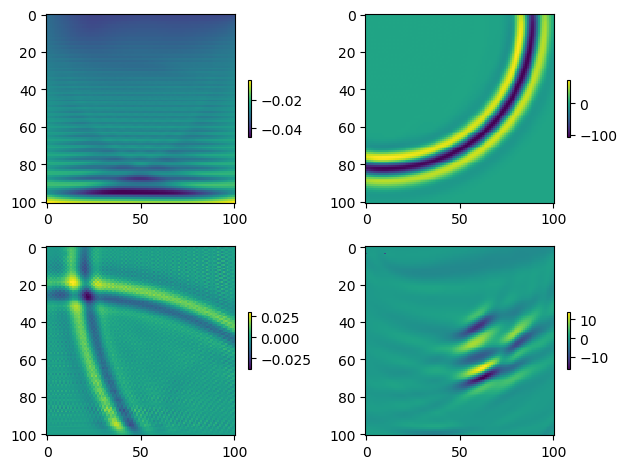

In [22]:
ttt = 500
subplot(221); imshow(v[:,:,ttt,2]); colorbar(shrink=0.3)
subplot(222); imshow(uu[:,:,ttt,2]); colorbar(shrink=0.3)
subplot(223); imshow(grad[:,:,ttt,2]); colorbar(shrink=0.3)
grad = sum(grad, dims=[3,4])
grad = grad[:,:,1,1]
subplot(224); imshow(grad); colorbar(shrink=0.3)
tight_layout()

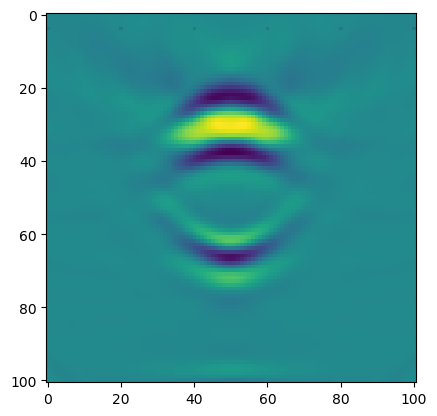

 20.559374 seconds (10.51 k allocations: 6.870 GiB, 1.86% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f4705224c50>

In [130]:
@time gg, dd = grad_sinkhorn_parallel(data-datac, u, data0-datac, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position;reg_p=0, pml_len=10, pml_coef=100, reg=5e-3, reg_m=1e2, iterMax=50, verbose=false);
imshow(gg)

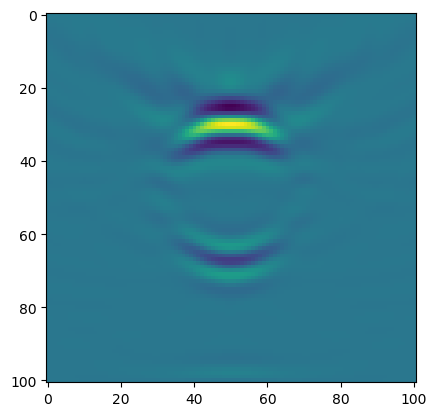

 18.856778 seconds (1.81 M allocations: 101.081 GiB, 18.32% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f47053df0b8>

In [131]:
@time ggl = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl)